# Synthetic Data Generation

Generate synthetic data with the generators listed below
Based on the Wisconsin Breast Cancer Dataset (WBCD)

In [1]:
# Standard library
import sys

sys.path.append("..")

# 3rd party packages
import matplotlib.pyplot as plt
import pandas as pd

# Local packages
import config
from clover.generators import (
    Generator,
    DataSynthesizerGenerator,
    SynthpopGenerator,
    SmoteGenerator,
    TVAEGenerator,
    CTGANGenerator,
    FinDiffGenerator,
    MSTGenerator,
    CTABGANGenerator,
)
import clover.utils.draw as draw
from clover.utils.standard import create_directory

/data8/install/anaconda3/envs/synthetic_data_p3.10_DP/lib/python3.10/site-packages/rdt/__init__.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import iter_entry_points


## Load the real WBCD training dataset

In [ ]:
df_real_train = pd.read_csv(
    "../data/" + config.WBCD_DATASET_TRAIN_FILEPATH.stem + ".csv"
)
df_real_test = pd.read_csv("../data/" + config.WBCD_DATASET_TEST_FILEPATH.stem + ".csv")
df_real_train.shape, df_real_test.shape

((359, 10), (90, 10))

In [3]:
df_real_train.head()

Clump_Thickness  Uniformity_of_Cell_Size  Uniformity_of_Cell_Shape  \
0               10                       10                        10   
1                5                        1                         2   
2                6                       10                         2   
3                4                        8                         6   
4                7                        4                         7   

   Marginal_Adhesion  Single_Epithelial_Cell_Size  Bare_Nuclei  \
0                  3                           10           10   
1                  1                            2            1   
2                  8                           10            2   
3                  4                            3            4   
4                  4                            3            7   

   Bland_Chromatin  Normal_Nucleoli  Mitoses  Class  
0                9               10        1      1  
1                1                1        1      0  
2                7                8       10      1  
3               10                6        1      1  
4                7                6        1      1

## Create the metadata dictionary

### The continuous and categorical variables need to be specified, as well as the variable to predict for the future learning task (used by SMOTE)

In [4]:
metadata = {
    "continuous": [
        "Clump_Thickness",
        "Uniformity_of_Cell_Size",
        "Uniformity_of_Cell_Shape",
        "Marginal_Adhesion",
        "Single_Epithelial_Cell_Size",
        "Bland_Chromatin",
        "Normal_Nucleoli",
        "Mitoses",
        "Bare_Nuclei",
    ],
    "categorical": ["Class"],
    "variable_to_predict": "Class",
}

## Choose the generator

In [5]:
generator = "synthpop"  # to choose among this list: ["synthpop", "smote", "datasynthesizer", "mst", "ctgan", "tvae", "ctabgan", "findiff"]
dp = False

### Synthpop

In [6]:
if generator == "synthpop":
    if not dp:
        gen = SynthpopGenerator(
            df=df_real_train,
            metadata=metadata,
            random_state=66,  # for reproducibility, can be set to None
            generator_filepath=None,  # to load an existing generator,
            variables_order=None,  # use the dataframe columns order by default
        )
    else:
        gen = SynthpopGenerator(
            df=df_real_train,
            metadata=metadata,
            random_state=66,  # for reproducibility, can be set to None
            generator_filepath=None,  # to load an existing generator,
            variables_order=None,  # use the dataframe columns order by default
            epsilon=10,
            max_depth=5,
        )

### SMOTE

In [7]:
if generator == "smote":
    if not dp:
        gen = SmoteGenerator(
            df=df_real_train,
            metadata=metadata,
            random_state=66,  # for reproducibility, can be set to None
            generator_filepath=None,  # to load an existing generator,
            k_neighbors=None,  # cannot be found by searching the best hyperparameters yet, set to 5 by default
        )
    else:
        gen = SmoteGenerator(
            df=df_real_train,
            metadata=metadata,
            random_state=66,  # for reproducibility, can be set to None
            generator_filepath=None,  # to load an existing generator,
            k_neighbors=5,  # cannot be found by searching the best hyperparameters yet, set to 5 by default
            epsilon=10,
        )

### Datasynthesizer

In [8]:
if generator == "datasynthesizer":
    if not dp:
        gen = DataSynthesizerGenerator(
            df=df_real_train,
            metadata=metadata,
            random_state=66,  # for reproducibility, can be set to None
            generator_filepath=None,  # to load an existing generator
            candidate_keys=None,  # the identifiers
            epsilon=0,  # for the differential privacy
            degree=2,  # the maximal number of parents for the bayesian network
        )
    else:
        gen = DataSynthesizerGenerator(
            df=df_real_train,
            metadata=metadata,
            random_state=66,  # for reproducibility, can be set to None
            generator_filepath=None,  # to load an existing generator
            candidate_keys=None,  # the identifiers
            epsilon=10,  # for the differential privacy
            degree=2,  # the maximal number of parents for the bayesian network
        )

### MST

In [9]:
# MST includes DP by design, hence non-dp mode is not available
if generator == "mst":
    gen = MSTGenerator(
        df=df_real_train,
        metadata=metadata,
        random_state=66,  # for reproducibility, can be set to None
        generator_filepath=None,  # to load an existing generator
        epsilon=10,  # the privacy budget of the differential privacy
        delta=1e-9,  # the failure probability of the differential privacy
    )

### CTGAN

In [10]:
if generator == "ctgan":
    if not dp:
        gen = CTGANGenerator(
            df=df_real_train,
            metadata=metadata,
            random_state=66,  # for reproducibility, can be set to None
            generator_filepath=None,  # to load an existing generator
            discriminator_steps=4,  # the number of discriminator updates to do for each generator update
            epochs=300,  # the number of training epochs
            batch_size=100,  # the batch size for training
        )
    else:
        gen = CTGANGenerator(
            df=df_real_train,
            metadata=metadata,
            random_state=66,  # for reproducibility, can be set to None
            generator_filepath=None,  # to load an existing generator
            discriminator_steps=4,  # the number of discriminator updates to do for each generator update
            epochs=300,  # the number of training epochs
            batch_size=100,  # the batch size for training
            epsilon=10,
            delta=1e-5,
        )

### TVAE

In [11]:
if generator == "tvae":
    if not dp:
        gen = TVAEGenerator(
            df=df_real_train,
            metadata=metadata,
            random_state=66,  # for reproducibility, can be set to None
            generator_filepath=None,  # to load an existing generator
            epochs=300,  # the number of training epochs
            batch_size=100,  # the batch size for training
            compress_dims=(249, 249),  # the size of the hidden layers in the encoder
            decompress_dims=(249, 249),  # the size of the hidden layers in the decoder
        )
    else:
        gen = TVAEGenerator(
            df=df_real_train,
            metadata=metadata,
            random_state=66,  # for reproducibility, can be set to None
            generator_filepath=None,  # to load an existing generator
            epochs=300,  # the number of training epochs
            batch_size=100,  # the batch size for training
            compress_dims=(249, 249),  # the size of the hidden layers in the encoder
            decompress_dims=(249, 249),  # the size of the hidden layers in the decoder
            epsilon=10,
            delta=1e-5,
        )

### CTAB-GAN+

In [12]:
if generator == "ctabgan":
    if not dp:
        gen = CTABGANGenerator(
            df=df_real_train,
            metadata=metadata,
            random_state=66,  # for reproducibility, can be set to None
            generator_filepath=None,  # to load an existing generator
            mixed_columns=None,  # dictionary of "mixed" column names with corresponding categorical modes
            log_columns=None,  # list of skewed exponential numerical columns
            integer_columns=metadata[
                "continuous"
            ],  # list of numeric columns without floating numbers
            class_dim=(
                256,
                256,
                256,
                256,
            ),  # size of each desired linear layer for the auxiliary classifier
            random_dim=100,  # dimension of the noise vector fed to the generator
            num_channels=64,  # number of channels in the convolutional layers of both the generator and the discriminator
            l2scale=1e-5,  # rate of weight decay used in the optimizer of the generator, discriminator and auxiliary classifier
            batch_size=150,  # batch size for training
            epochs=500,  # number of training epochs
        )
    else:
        gen = CTABGANGenerator(
            df=df_real_train,
            metadata=metadata,
            random_state=66,  # for reproducibility, can be set to None
            generator_filepath=None,  # to load an existing generator
            mixed_columns=None,  # dictionary of "mixed" column names with corresponding categorical modes
            log_columns=None,  # list of skewed exponential numerical columns
            integer_columns=metadata[
                "continuous"
            ],  # list of numeric columns without floating numbers
            class_dim=(
                32,
                32,
                32,
                32,
            ),  # size of each desired linear layer for the auxiliary classifier
            random_dim=10,  # dimension of the noise vector fed to the generator
            num_channels=8,  # number of channels in the convolutional layers of both the generator and the discriminator
            l2scale=1e-5,  # rate of weight decay used in the optimizer of the generator, discriminator and auxiliary classifier
            batch_size=150,  # batch size for training
            epochs=10,  # number of training epochs
            epsilon=10,
            delta=1e-5,
        )

### FinDiff

In [13]:
if generator == "findiff":
    if not dp:
        gen = FinDiffGenerator(
            df=df_real_train,
            metadata=metadata,
            random_state=66,  # for reproducibility, can be set to None
            generator_filepath=None,  # to load an existing generator
            learning_rate=1e-4,  # the learning rate for training
            batch_size=512,  # the batch size for training and sampling
            diffusion_steps=500,  # the diffusion timesteps for the forward diffusion process
            epochs=500,  # the training iterations
            mpl_layers=[1024, 1024, 1024, 1024],  # the width of the MLP layers
            activation="lrelu",  # the activation fuction
            dim_t=64,  # dimensionality of the intermediate layer for connecting the embeddings
            cat_emb_dim=2,  # dimension of categorical embeddings
            diff_beta_start_end=[1e-4, 0.02],  # diffusion start and end betas
            scheduler="linear",  # diffusion scheduler
        )
    else:
        gen = FinDiffGenerator(
            df=df_real_train,
            metadata=metadata,
            random_state=66,  # for reproducibility, can be set to None
            generator_filepath=None,  # to load an existing generator
            learning_rate=1e-4,  # the learning rate for training
            batch_size=512,  # the batch size for training and sampling
            diffusion_steps=500,  # the diffusion timesteps for the forward diffusion process
            epochs=500,  # the training iterations
            mpl_layers=[1024, 1024, 1024, 1024],  # the width of the MLP layers
            activation="lrelu",  # the activation fuction
            dim_t=64,  # dimensionality of the intermediate layer for connecting the embeddings
            cat_emb_dim=2,  # dimension of categorical embeddings
            diff_beta_start_end=[1e-4, 0.02],  # diffusion start and end betas
            scheduler="linear",  # diffusion scheduler
            epsilon=1,  # value for DP parameter (delta is at default value 1e-5)
        )

## Fit the generator to the real data

In [14]:
create_directory(path="../results/generators")  # create path if doesn't exist

gen.preprocess()
gen.fit(save_path="../results/generators")  # the path should exist

## Display the fitted generator

In [15]:
gen.display()

Constructed sequential trees:
   Clump_Thickness has parents []
   Uniformity_of_Cell_Size has parents ['Clump_Thickness']
   Uniformity_of_Cell_Shape has parents ['Clump_Thickness', 'Uniformity_of_Cell_Size']
   Marginal_Adhesion has parents ['Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape']
   Single_Epithelial_Cell_Size has parents ['Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape', 'Marginal_Adhesion']
   Bare_Nuclei has parents ['Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape', 'Marginal_Adhesion', 'Single_Epithelial_Cell_Size']
   Bland_Chromatin has parents ['Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape', 'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei']
   Normal_Nucleoli has parents ['Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape', 'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin']
   Mitoses has parents [

## Generate the synthetic data

In [16]:
create_directory(path="../results/data")  # create path if doesn't exist

df_synth_train = gen.sample(
    save_path="../results/data",  # the path should exist
    num_samples=len(
        df_real_train
    ),  # can be different from the real data, but for computing the utility metrics should be the same
)

df_synth_test = gen.sample(
    save_path="../results/data",  # the path should exist
    num_samples=len(
        df_real_test
    ),  # can be different from the real data, but for computing the utility metrics should be the same
)

In [17]:
df_synth_train.head()

Clump_Thickness  Uniformity_of_Cell_Size  Uniformity_of_Cell_Shape  \
0                1                        1                         1   
1                5                        8                         7   
2                1                        1                         1   
3                9                        6                         4   
4               10                        4                         6   

   Marginal_Adhesion  Single_Epithelial_Cell_Size  Bare_Nuclei  \
0                  1                            2            2   
1                  8                            8            8   
2                  1                            2            2   
3                  1                           10           10   
4                 10                            4           10   

   Bland_Chromatin  Normal_Nucleoli  Mitoses Class  
0                7                1        1     0  
1                8                1        1     1  
2                2                1        1     0  
3                7                8        1     1  
4                5                9        2     1

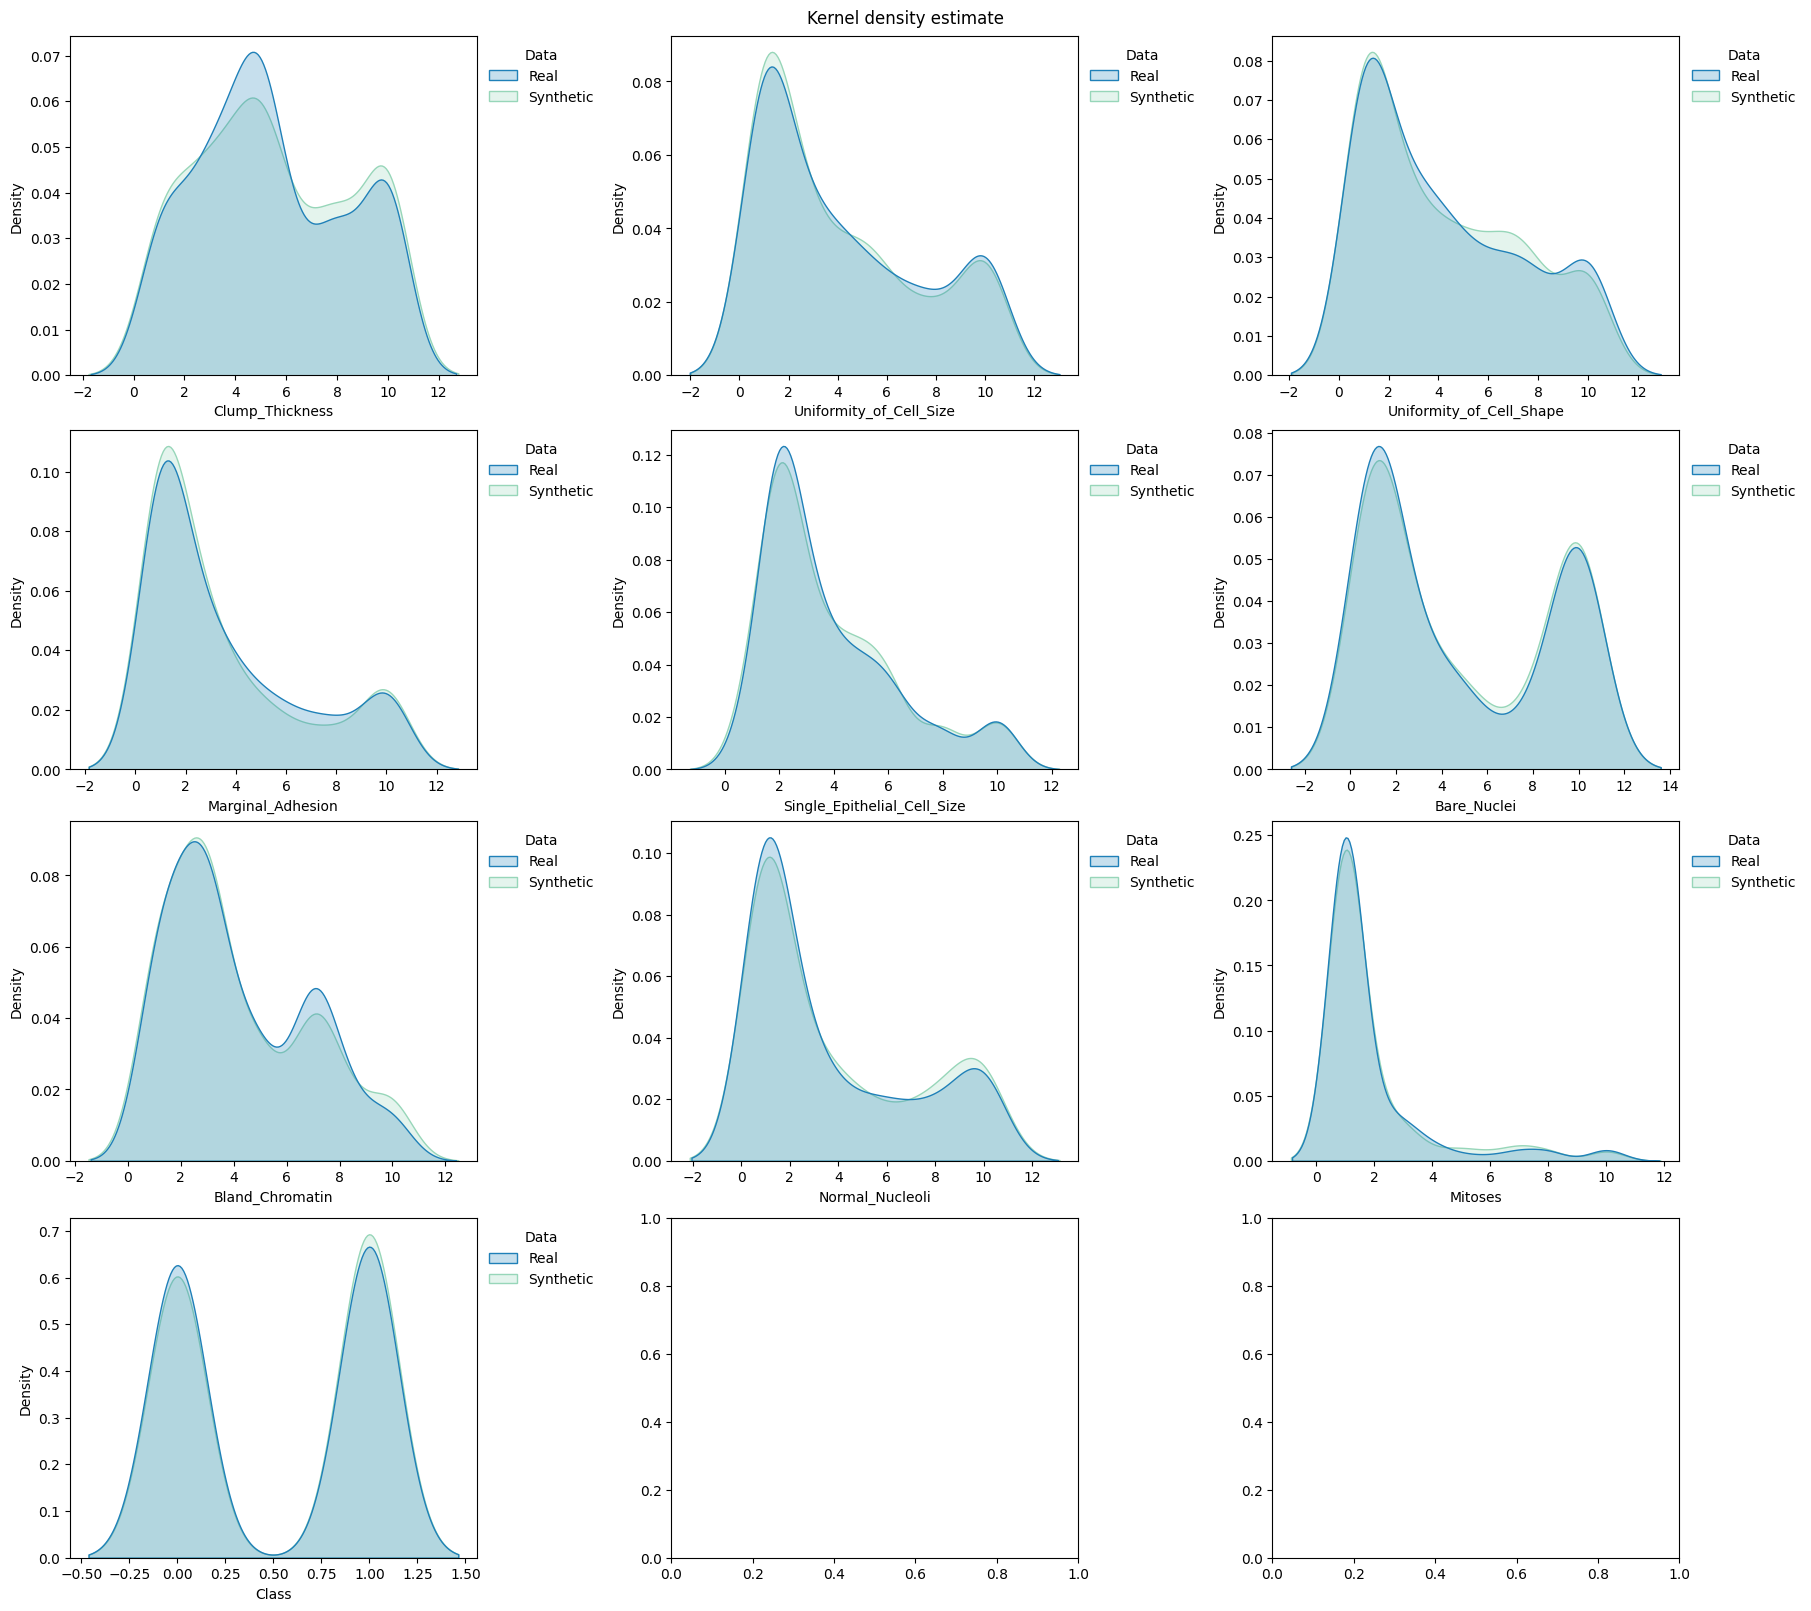

In [18]:
fig, axes = plt.subplots(  # manually set number of cols/rows
    nrows=4, ncols=3, squeeze=0, figsize=(18, 16), layout="constrained"
)
axes = axes.reshape(-1)
draw.kde_plot_hue_plot_per_col(
    df=df_real_train,
    df_nested=df_synth_train,
    original_name="Real",
    nested_name="Synthetic",
    hue_name="Data",
    title="Kernel density estimate",
    axes=axes,
)